In [1]:
""" This is the tutorial in how to use the Joker taken from the documentation page. """
from thejoker.data import RVData
from thejoker.plot import plot_rv_curves
from thejoker.sampler import compute_likelihoods
import astropy.units as  u
import matplotlib.pyplot as plt
import numpy as np
import schwimmbad
t = [0., 49.452, 95.393, 127.587, 38.31] * u.d
rv_dat = [38.77, 39.70, 37.45, 38.31, 38.31]* u.km/u.s
err = [0.184, 0.261, 0.112, 0.155, 0.233] * u.km/u.s

#t = [0.0, 2.9883000003173947, 27.93244000012055, 30.923119999933988, 35.92739999992773, 
#     63.85682999994606, 66.85045000026003]
#rv =[25.313385, 25.192486, 25.721413, 25.3508, 25.458048, 25.524765, 25.467243] * u.km/u.s
#err = [0.026613813, 0.04872429, 0.029271094, 0.026994251, 0.033509318] * u
data = RVData(t = t, rv=rv_dat, stddev = err)
ax = data.plot()
ax.set_xlim(-10,200)
ax.set_xlabel("Time [day]")
ax.set_ylabel("RV [km/s]")
plt.show(ax)

/home/cody/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [27]:
rnd = np.random.RandomState()
a, b = (np.log(8), np.log(512))
np.exp(rnd.uniform(a,b, size = 1))*u.day

<Quantity [20.52516519] d>

In [21]:
rnd = np.random.RandomState(1)
rnd.uniform(0,2)

0.834044009405148

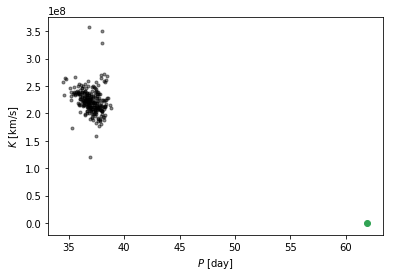

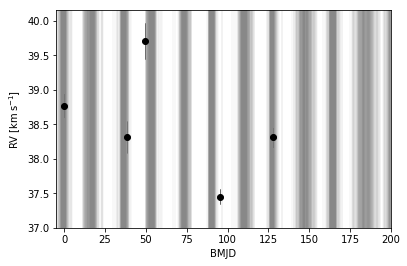

In [68]:
from thejoker.sampler import TheJoker
from thejoker.sampler import JokerParams
#From The Joker that gets possible paramiters that fit the data. The range of max and minimum periods have no ryme 
#or reason to them I just picked them becasue they seam reasonable. 
params = JokerParams(P_min = 8*u.day, P_max= 512*u.day)
joker = TheJoker(params)
#samples = joker.rejection_sample(data, n_prior_samples = 2**16)
name_thing = 'name thing?'
fig, ax = plt.subplots(1,1)
ax.scatter(samples['P'].value, samples['K'].to(u.km/u.s).value,
           marker='.', color= 'k',alpha=0.45)
ax.set_xlabel('$P$ [day]')
ax.set_ylabel('$K$ [km/s]')
#ax.set_xlim(-5,128)
#ax.set_ylim(0.75, 3.)

ax.scatter(61.942, 1.3959, marker='o', color='#31a354', zorder=-100)

fig, ax = plt.subplots(1,1)
t_grid = np.linspace(-5,200,1024)
plot_rv_curves(samples, t_grid, rv_unit =u.km/u.s, data = data, ax=ax,
              plot_kwargs=dict(color='#888888'),relative_to_t0=False)
data = RVData(t = t, rv=rv_dat, stddev = err)
ax = data.plot()
#ax.set_xlim(-5,100)
#ax.set_ylim(25.1,26.8)
plt.show()

In [64]:
modle, samples = joker.mcmc_sample(data,samples)

/home/cody/anaconda3/lib/python3.6/site-packages/thejoker/sampler/mcmc.py:47: RuntimeWarning: divide by zero encountered in log
  self._y_jitter = 2 * np.log(s.to(self._rv_unit).value)


In [69]:
len(samples['P'])

256

In [5]:
#This Is going through and doing all the things that plot_rv_curves does, but by doing this I can get back the 
#pridicted analytical radial velocities
import astropy.units as u
import numpy as np

from astropy.time import Time
from twobody import KeplerOrbit
from astropy.time import Time

from astropy.table import Table
from twobody.wrap import cy_rv_from_elements
from twobody.utils import ArrayProcessor

#Loop through all the different good samples that survive rejection. 
chi_2 = np.zeros(len(samples))
chi_2_red = np.zeros(len(samples))
ln_L = np.zeros(len(samples))
for n in range(len(samples)):
    
    #For each of the samples read in their respective orbital paramiters. I haven't read in jitter becasue in all of
    #my cases I've set the jitter to be zero
    P = samples['P'][n]
    e = samples['e'][n]
    M0 = samples['M0'][n]
    omega = samples['omega'][n]
    K = samples['K'][n]
    v0 = samples['v0'][n]
    s = samples['jitter'][n]
    #t_foo = np.linspace(t[0], 200,1024) #make a lin space for the radial velocity plot. Must start at the starting point
                                        #of the data, if not then the radial velocity curves will be off set 
   
    #t_foo = Time(t_foo, format = 'mjd')
    t_dat = Time(t, format = 'mjd')

    #t_foo = t_foo.tcb.mjd
    t_dat = t_dat.tcb.mjd

    #proc = ArrayProcessor(t_foo)
    proc2 = ArrayProcessor(t_dat)

    #t_foo, = proc.prepare_arrays()
    t_dat, = proc2.prepare_arrays()

    #t0  = t_foo[0]
    td0 = t_dat[0]

    #t0  = Time(t0 , format = 'mjd')
    td0 = Time(td0, format = 'mjd')
    
    
    #Several warnings pop up when running this. Something about certain time values giving "dubious year (Note 3/4)" 
    #But it runs fine without it
    #rv = cy_rv_from_elements(t_foo, P.to(u.day).value, 1., e, omega.to(u.radian).value,
    #                         M0.to(u.radian).value, t0.tcb.mjd, 
    #                         anomaly_tol = 1E-10, anomaly_maxiter = 128)
    
    rv_an = cy_rv_from_elements(t_dat, P.to(u.day).value, 1., e, omega.value,
                             M0.value, td0.tcb.mjd, 
                             anomaly_tol = 1E-10, anomaly_maxiter = 128)
    #rv = K*rv + v0
    
    #rv_an is the analytical radial velocity evaluated at the times that we made the actual observations
    rv_an = K*rv_an + v0

    #plt.plot(t_foo,rv,color='#555555' ,linestyle = '-', marker = '', alpha = 0.05 + 4./(len(samples) + 4.), rasterized = True)
    
    #data = RVData(t = t, rv=rv_dat, stddev = err)
    #ax = data.plot()
    #ax.set_xlim(-5,200)
    #ax.set_xlabel("Time [day]")
    #ax.set_ylabel("RV [km/s]")
    #Now that I have an 'analytic' radial velocity i want to find the ln_likelihood
    diff = (rv_dat - rv_an)**2
    chi_2[n] = sum(diff /((err)**2 + s**2))
    chi_term = diff /((err)**2  + s**2)
    # Can't use a reduced chi squared because often the number of data points we have is less than the number
    # of paramiters to our best fit equation. 
    #chi_2_red[n] = chi_2[n] / (len(data) - 6)
    thing_2b_summed = chi_term + np.log(2*np.pi*(err.value**2 + s.value**2))
    ln_L[n] = -0.5*sum(thing_2b_summed)
    
ax.set_xlim(-5,200)
ax.set_ylim(37,40)
plt.show(ax) 


In [6]:
plt.show(ax)

In [7]:
print( ln_L, '\n', chi_2, "\n", chi_2_red)

[-0.1138191   0.97253307  0.7527951   2.83761172 -0.3688792   1.43723438
  2.40706276  3.06088936  3.48216059  3.62079911 -3.15449756  2.77154683
 -2.13475607  0.11174475  2.60879573  3.05865781  0.59072667  2.24061189
  2.48798167 -1.05342424  2.21005947  0.30837453  3.31061035  1.51958747
  1.97670537  0.16264366  1.58383972 -3.28407853  1.20001153  3.45777989
 -2.7854635  -0.16116544  1.80897559 -4.67712153 -0.37768343 -5.36936109
  2.61583235  1.69737105  1.11500207  2.51749067  0.53397829  2.58752341
 -0.43079884  1.56418853  2.32630253  3.69689011  3.39780848  2.59882491
  1.59407969  2.65154081  2.38025342 -1.67220033  0.8706388   1.34760352] 
 [ 8.13096845  5.95826411  6.39774004  2.2281068   8.64108865  5.02886149
  3.08920473  1.78155153  0.93900907  0.66173202 14.21232537  2.36023658
 12.17284238  7.67984075  2.68573878  1.78601462  6.7218769   3.42210646
  2.9273669  10.01017872  3.4832113   7.28658118  1.28210955  4.8641553
  3.9499195   7.57804293  4.7356508  14.4714873  

In [21]:
print( ln_L, '\n', chi_2)

[ 2.49805541  2.00385311  3.26966903  1.96258157  1.91792313  2.52796246
 -0.95465186  1.93329231 -1.47173921 -1.70773027  2.83030418 -2.48976459
  1.63819941 -1.5983893   0.94810834  2.1065376  -5.37858322  0.56129142
  1.95971985 -2.75122792  0.96213567  2.55589907  1.25679157  2.15488986
 -0.27633615 -0.81656623  2.3676054   3.16521392 -1.63262462  1.76312277
 -0.60465712  0.417777    1.46469145  2.74939564  1.88057947  1.38008995
 -1.46500416  2.23661875  1.5011411  -0.81891106 -2.01613838  3.01025816
  1.04597125  2.52144802  1.97589346  2.30163804  1.05013267  3.28593322
 -1.66953043  2.40547314  2.51310367  1.64922803  2.81756289  2.03561563
  2.43982215 -0.37450896 -0.32098072  3.46380694  1.92010583 -3.84087361
  2.08197904  0.73021974  0.95752751  1.04424136  2.31834387  2.33134088
  0.58767509 -3.18271154  1.60857667  2.16320738 -3.09081033  1.07710759
  2.70423853  3.07085271  1.54167336] 
 [ 2.90721943  3.89562403  1.36399219  3.97816711  4.06748398  2.84740532
  9.8126339

In [21]:
T = (max(t) - min(t)).value
Delta = (4*np.median(samples['P'].value**2)) / (2*np.pi * T)
P_rms = np.sqrt(np.mean(samples['P'].value**2))
P_var = np.sqrt(np.var(samples['P'].value))
print( T, Delta, P_rms,P_var)

127.587 1.618736048651312 41.474913887592386 25.616314472698207


1.5

# I want to mess around with the _.rejection_sample for a little while to see exactly how it's going about doing this around not having K or v0 and how it commes up with those values after it does the marginalization over the non-linear paramiters

In [129]:
from thejoker.data import RVData
from thejoker.plot import plot_rv_curves
from thejoker.sampler import compute_likelihoods
import astropy.units as  u
import matplotlib.pyplot as plt
import numpy as np
import schwimmbad
import tempfile
from thejoker.sampler import TheJoker
from thejoker.sampler import JokerParams
from thejoker.sampler import multiproc_helpers
t = [0., 49.452, 95.393, 127.587, 38.31] * u.d
rv_dat = [38.77, 39.70, 37.45, 38.31, 38.31]* u.km/u.s
err = [0.184, 0.261, 0.112, 0.155, 0.233] * u.km/u.s

data = RVData(t = t, rv=rv_dat, stddev = err)

In [113]:
params = JokerParams(P_min = 8*u.day, P_max= 512*u.day)
joker = TheJoker(params)
start_idx = 0
pool = schwimmbad.SerialPool()

In [115]:
import thejoker.sampler
n_prior_samples = 2**3
prior_cache_file = None
n_batches = None

In [140]:
from thejoker.sampler import io
n_prior_samples, cache_exists = joker._validate_prior_cache(n_prior_samples=2**3, prior_cache_file=None)
with tempfile.NamedTemporaryFile(mode = 'r+') as f:
    prior_cache_file = f.name
    prior_samples = joker.sample_prior(2**3)
    prior_units = io.save_prior_samples(prior_cache_file, prior_samples, data.rv.unit)
    #result = joker._rejection_sample_from_cache(data, n_prior_samples,prior_cache_file,start_idx=0,
    #                                             seed = None ,return_logprobs=False) 
    #marg_lls = compute_likelihoods(n_prior_samples, prior_cache_file, start_idx,data, params, pool,
    #                           n_batches)
    #Still to much going on in this so I'm going to dive into how this works.
    args = [prior_cache_file, data, params]
    if n_batches is None:
        n_batches = pool.size
    tasks = multiproc_helpers.chunk_tasks(n_prior_samples, n_batches, args = args, start_idx = 0)
    #results = [r for r in pool.map(multiproc_helpers._marginal_ll_worker, tasks
    
    #How does _marfinal_ll_worker, work? Mainly just calls batch_marginal_ln_likelihood, cuts it up into batches
    # first for parrallelization.
    

After running this last section I've done the rejection sampling, I went from a random batch of 2^18 samples in [p,e,M0,omega]. After doing the random rejection I've been left with 55. The output 'result' is a numpy.ndarray. It doesn't have units I want to still dive into what _rejection_sample_fom_cache_ does so I'm not going to run it but run all the things it calls individually. 

In [120]:
prior_samples

JokerSamples([('P',
               <Quantity [279.40843391,  28.79886281, 118.41569201,  49.82045649,
                          424.93137328, 271.42461562, 172.84698413, 304.03136451] d>),
              ('M0',
               <Quantity [2.18916589, 3.38790059, 2.63794706, 1.14584799, 4.14965503,
                          6.04096116, 0.08169327, 5.41519338] rad>),
              ('e',
               <Quantity [0.42187487, 0.19919702, 0.514397  , 0.10360886, 0.04020911,
                          0.1505639 , 0.54001322, 0.1323107 ]>),
              ('omega',
               <Quantity [0.931598  , 5.57325539, 3.76062018, 5.74371535, 6.14352925,
                          4.08394685, 4.29176408, 4.55321679] rad>),
              ('jitter', <Quantity [0., 0., 0., 0., 0., 0., 0., 0.] km / s>)])

(array([4033., 3273., 2977., 2717., 2553., 2426., 2368., 2179., 2230.,
        1968., 1977., 1859., 1759., 1699., 1608., 1559., 1515., 1378.,
        1418., 1336., 1191., 1176., 1145., 1116., 1046., 1048.,  971.,
         916.,  922.,  848.,  841.,  779.,  739.,  688.,  684.,  649.,
         584.,  596.,  558.,  499.,  485.,  450.,  412.,  401.,  373.,
         314.,  321.,  307.,  260.,  243.,  230.,  219.,  217.,  177.,
         160.,  153.,  124.,  126.,  127.,   97.,   79.,   79.,   70.,
          57.,   55.,   51.,   38.,   23.,   16.,   15.,   13.,    8.,
           8.]),
 array([2.55067032e-06, 1.30593028e-02, 2.61160550e-02, 3.91728072e-02,
        5.22295593e-02, 6.52863115e-02, 7.83430636e-02, 9.13998158e-02,
        1.04456568e-01, 1.17513320e-01, 1.30570072e-01, 1.43626824e-01,
        1.56683577e-01, 1.69740329e-01, 1.82797081e-01, 1.95853833e-01,
        2.08910585e-01, 2.21967337e-01, 2.35024090e-01, 2.48080842e-01,
        2.61137594e-01, 2.74194346e-01, 2.87251098e-01,

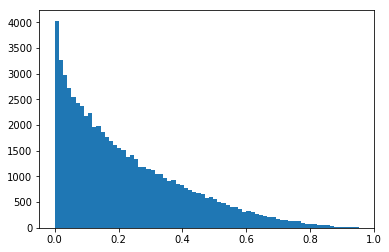

In [99]:
plt.hist(e, bins = 'auto')

262144